In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression


In [ ]:
df = pd.read_csv('csv/helpdesk_customer_tickets.csv')
df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9
530,3061399426554,Inquiry About MacBook Air M1 Features,"Dear Customer Support Team, \r\n\r\nI hope thi...","Dear <name>,\r\n\r\nThank you for your inquiry...",Request,Sales and Pre-Sales,low,en,Tech Online Store,Product Support,Sales Inquiry,Technical Support,General Inquiry,Warranty Claim,Customer Service,Feature Request,NaN,NaN
57,1225616442299,Demande de haute priorité : Problèmes d'admini...,"Cher support client,\r\n\r\nJe vous écris pour...","Cher <name>,\r\n\r\nMerci de nous avoir contac...",Request,Technical Support,high,fr,IT Services,Technical Support,IT Support,Urgent Issue,Service Disruption,System Maintenance,Problem Resolution,NaN,NaN,NaN
459,2773728793151,Problème d'écran de MacBook Air,"Bonjour,\r\n\r\nJe rencontre des scintillement...","Bonjour <name>,\r\n\r\nJe suis désolé d'appren...",Incident,Customer Service,medium,fr,Tech Online Store,Technical Support,Product Support,Software Bug,Hardware Failure,Problem Resolution,Urgent Issue,NaN,NaN,NaN


### **Analysis**
- While the model accuracy and precision comes out to be very good, when testing from user perspective, I find that the output by the model is not as accurate as I'd want 
- Due to keyword importance conflicts, I removed type and queue and just added the processed text (subject and body) as feature for the model
- After analysis, I find that the words present in the tags can also help the model to better classify

In [4]:
# combine all tags to one column, ignore tags with NaN tage 1-9
df['tags'] = df[['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'tag_9']].apply(lambda x: ' '.join(x.dropna()), axis=1)
df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tags
832,4624848243405,High Priority Request: Server Administration I...,"Dear Customer Support,\r\n\r\nI am writing to ...","Dear <name>,\r\n\r\nThank you for reaching out...",Request,Technical Support,high,en,IT Services,Technical Support,IT Support,Urgent Issue,Service Disruption,Problem Resolution,NaN,NaN,NaN,NaN,Technical Support IT Support Urgent Issue Serv...
1509,9610822965658,Solicitação de Alterações no Painel de Gerenci...,"Caro Suporte ao Cliente dos Serviços de TI,\r\...","Caro <name>,\r\n\r\nObrigado por entrar em con...",Change,Product Support,high,pt,IT Services,Technical Support,IT Support,Problem Resolution,Product Support,Performance Tuning,Service Notification,NaN,NaN,NaN,Technical Support IT Support Problem Resolutio...
743,4154074065231,Problemas de Mensajería en Tiempo Real,Estimado equipo de soporte de Tech Online Stor...,"Estimado <name>,\r\n\r\nGracias por ponerte en...",Incident,Technical Support,high,es,Tech Online Store,Technical Support,Software Bug,Service Disruption,Performance Tuning,Urgent Issue,Problem Resolution,NaN,NaN,NaN,Technical Support Software Bug Service Disrupt...


In [5]:
df.drop(['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'tag_9'], axis=1, inplace=True)

In [6]:
df.sample(10)

,id,subject,body,answer,type,queue,priority,language,business_type,tags
143,1476860896719,Assistance Required: Issue with Adobe Photosho...,"Dear Customer Support, \r\n\r\nI am writing to...","Dear <name>,\r\n\r\nThank you for reaching out...",Incident,Product Support,medium,en,Tech Online Store,Technical Support Software Bug Product Support...
1459,9151130469375,Problemas frecuentes de desconexión con el rou...,"A quien corresponda, estoy escribiendo para in...",Asunto: Asistencia con problemas de conexión d...,Problem,Technical Support,high,es,IT Consulting Firm,Technical Support Network Issue Service Disrup...
133,1451928343055,Anfrage um Unterstützung: Router verursacht Ne...,"Sehr geehrtes Kundenserviceteam,\r\n\r\nich we...","Sehr geehrter <name>,\r\n\r\nvielen Dank, dass...",Incident,IT Support,high,de,IT Services,Technical Support Network Issue Service Disrup...
1377,8602895627286,Erforderliche Änderungen für das IT-Ticket-Sys...,"Sehr geehrter Kundenservice,\r\n\r\nich schrei...","Sehr geehrter <name>,\r\n\r\nvielen Dank, dass...",Change,Customer Service,high,de,IT Consulting Firm,Technical Support Product Support IT Support F...
694,3913042785256,Solicitação de Assistência para Administração ...,"Prezado Suporte ao Cliente de Serviços de TI,\...","Prezado <name>,\r\n\r\nObrigado por entrar em ...",Request,Customer Service,medium,pt,IT Services,Technical Support IT Support System Maintenanc...
301,2115243427404,Necesito soporte urgente,"Hola,\r\n\r\nEstoy escribiendo para solicitar ...",Asunto: Re: Necesito soporte urgente\r\n\r\nHo...,Request,Customer Service,high,es,IT Services,Technical Support IT Support Network Issue Urg...
367,2374984938313,Network Outage Due to Cisco Router ISR4331 Fai...,"Dear Customer Support,\r\n\r\nWe are experienc...","Dear <name>,\r\n\r\nThank you for reaching out...",Incident,Technical Support,high,en,IT Services,Network Issue Service Outage Urgent Issue Tech...
1481,9321485168154,Assistance Urgente Nécessaire,"Cher Service de Support Informatique,\r\n\r\nJ...","Cher <name>,\r\n\r\nMerci de nous avoir contac...",Problem,IT Support,high,fr,IT Services,IT Support Urgent Issue Service Disruption Tec...
1183,7078595265468,Solicitação de Upgrade do Zoom,"Caro Suporte ao Cliente,\r\n\r\nEspero que est...","Caro <name>,\r\n\r\nObrigado por entrar em con...",Change,Technical Support,high,pt,IT Services,Technical Support Software Bug Feature Request...
952,5399207066742,Solicitud de cambios en la configuración del s...,"Estimado equipo de soporte al cliente,\r\n\r\n...","Estimado <name>,\r\n\r\nGracias por ponerte en...",Change,IT Support,medium,es,IT Services,Technical Support IT Support Performance Tunin...


### Tokenize and lemmatize function

In [7]:
import spacy

nlp = spacy.load('en_core_web_sm')

# create function to preprocess text
def preprocess_text(text):
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').strip().lower()
    doc = nlp(text)
    preprocessed_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(preprocessed_tokens)


In [8]:
# preprocess the tags
df['tags'] = df['tags'].apply(preprocess_text)

In [9]:
df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tags
1215,7259013336804,IntelliJ IDEA 2024.1 Abstürze nach Update,"Sehr geehrter Kundendienst, ich schreibe, um e...",Betreff: AW: IntelliJ IDEA 2024.1 Abstürze nac...,Incident,Product Support,high,de,Software Development Company,software bug technical support problem resolut...
1329,8101855342708,Dringend: Papierstau-Problem bei Epson EcoTank...,"Ich schreibe, um technische Unterstützung für ...","Vielen Dank, dass Sie uns wegen des Papierstau...",Request,Technical Support,high,de,Tech Online Store,technical support product support hardware fai...
1203,7193160644333,Dringend: Häufige PostgreSQL-Server-Abstürze,"Sehr geehrter Kundenservice,\r\n\r\nich schrei...","Sehr geehrter <name>,\r\n\r\nvielen Dank, dass...",Problem,Technical Support,high,de,IT Consulting Firm,technical support system crash urgent issue se...


In [10]:
df.dropna(subset=['subject', 'body'], inplace=True)

df['subject'] = df['subject'].apply(preprocess_text)
df['body'] = df['body'].apply(preprocess_text)

df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tags
650,3673305957846,experienciando problemas de qualidade de vídeo...,ajuda urgente necessária para problemas de víd...,"Por favor, atualize o Zoom e ajuste as configu...",Problem,Technical Support,high,pt,Tech Online Store,technical support urgent issue software bug pr...
1391,8711623412992,problema de discrepancia de facturación,estimado equipo de soporte de servicios de ti ...,"Estimado <name>,\r\n\r\nGracias por ponerte en...",Incident,Billing and Payments,medium,es,IT Services,billing issue customer service problem resolut...
237,1859442217727,dringend probleme mit dem aws management service,sehr geehrter kundendienst ich schreibe um...,Betreff: Re: Dringend: Probleme mit dem AWS Ma...,Incident,Technical Support,high,de,IT Services,urgent issue technical support service disrupt...


In [11]:
df['processed_text'] = df['subject'] + ' ' + df['body'] + ' ' + df['tags']

# Remove all non-english records
df_en = df[df.language == 'en']

In [12]:
df_en = df_en[['processed_text', 'type', 'queue', 'priority']]
df_en.sample(10)

,processed_text,type,queue,priority
874,issue aw billing charge dear customer support ...,Problem,Billing and Payments,low
1041,billing discrepancy issue dear service support...,Incident,Billing and Payments,medium
993,billing discrepancy dear customer support team...,Incident,Billing and Payments,medium
725,issue dell xps 13 power dear tech online store...,Incident,Technical Support,high
528,request server consultation dear customer supp...,Request,Customer Service,medium
809,zoom 5.11.0 connection issue hello experie...,Incident,Technical Support,high
256,frequent disconnect issue cisco router isr4331...,Problem,Technical Support,high
1058,request support router cause network issue dea...,Incident,IT Support,high
1129,assistance need macbook air m1 keyboard dear t...,Request,Product Support,medium
146,frequent audio issue zoom application dear cus...,Incident,Technical Support,low


### Data Visualization

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

high_priority = df_en[df_en.priority == 'high']
medium_priority = df_en[df_en.priority == 'medium']
low_priority = df_en[df_en.priority == 'low']

def tfidf_vectorizer(text):
    tdidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
    tdidf_matrix = tdidf_vectorizer.fit_transform(text)
    feature_names = tdidf_vectorizer.get_feature_names_out()
    word_scores = zip(feature_names, tdidf_matrix.sum(axis=0).tolist()[0])

    top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
    return top_words

high_priority_top_words = tfidf_vectorizer(high_priority['processed_text'])
medium_priority_top_words = tfidf_vectorizer(medium_priority['processed_text'])
low_priority_top_words = tfidf_vectorizer(low_priority['processed_text'])

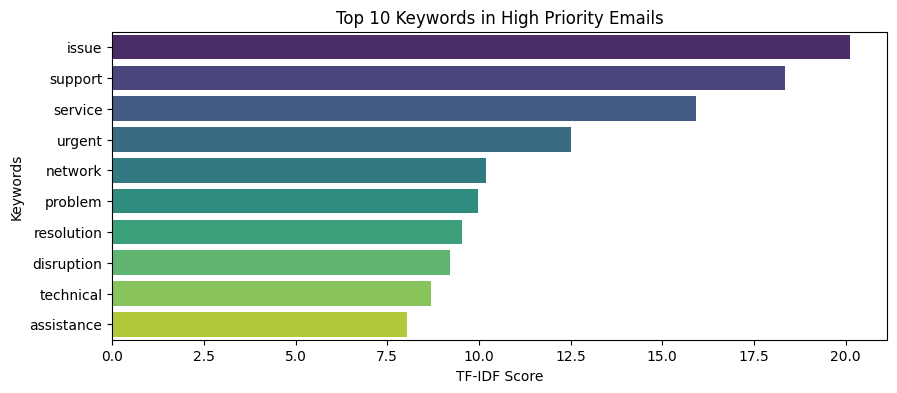

In [14]:
keywords, frequencies = zip(*high_priority_top_words)

plt.figure(figsize=(10, 4))
sns.barplot(x=frequencies, y=keywords, palette='viridis', hue=keywords)
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 10 Keywords in High Priority Emails')
plt.show()

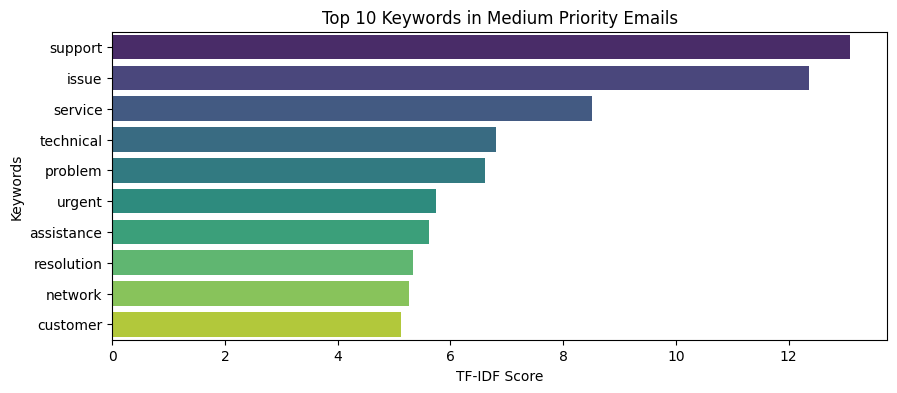

In [15]:
keywords, frequencies = zip(*medium_priority_top_words)

plt.figure(figsize=(10, 4))
sns.barplot(x=frequencies, y=keywords, palette='viridis', hue=keywords)
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 10 Keywords in Medium Priority Emails')
plt.show()

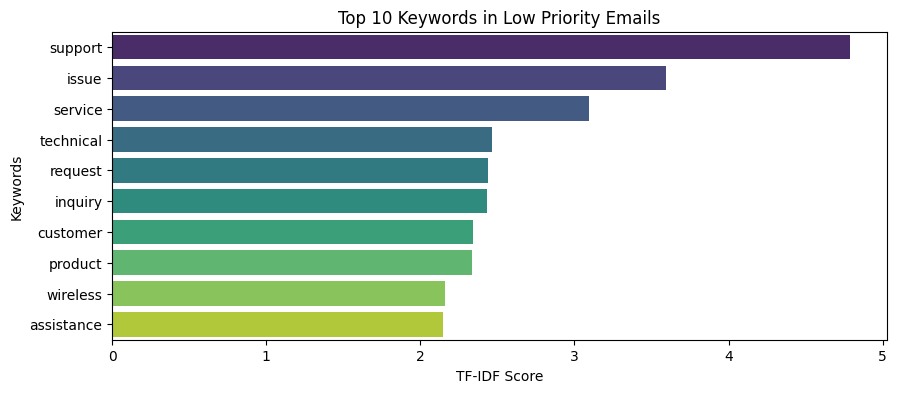

In [16]:
keywords, frequencies = zip(*low_priority_top_words)

plt.figure(figsize=(10, 4))
sns.barplot(x=frequencies, y=keywords, palette='viridis', hue=keywords)
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 10 Keywords in Low Priority Emails')
plt.show()

### Model Training - Logistic Regression
**Why?** 
- Good for simple data 
- Fast

**Cons**
- Assumes linear relationship 
- Sensitive to outliers

In [17]:
df_en.shape

(338, 4)

In [18]:
df_en.sample(3)

,processed_text,type,queue,priority
117,intermittent network connectivity issue dear c...,Incident,Technical Support,medium
305,immediate assistance require dear support team...,Incident,Technical Support,high
48,urgent user unable join schedule zoom meeting ...,Incident,Technical Support,high


In [28]:
df_en.to_csv('csv/processed_tickets_en.csv', index=False)

In [22]:
X = df_en[['processed_text']]
y = df_en['priority']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Building the TF-IDF transformer and model pipeline
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text_tfidf', text_transformer, 'processed_text')
    ],
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [24]:
# Train the model
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.80      0.80      0.80        40
         low       0.00      0.00      0.00         9
      medium       0.46      0.68      0.55        19

    accuracy                           0.66        68
   macro avg       0.42      0.49      0.45        68
weighted avg       0.60      0.66      0.63        68



c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Model Training 

In [25]:
from sklearn.svm import SVC

pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

In [27]:
pipeline_svm.fit(X_train, y_train)

y_pred_svm = pipeline_svm.predict(X_test)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

        high       0.77      0.75      0.76        40
         low       0.00      0.00      0.00         9
      medium       0.41      0.63      0.50        19

    accuracy                           0.62        68
   macro avg       0.39      0.46      0.42        68
weighted avg       0.57      0.62      0.59        68



c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo